The goal of this lab is to optimize a Random Forest model using the provided dataset.  The guidance this week is less prescriptive in terms of steps, so use the skills you have gained over the semester to build and evaluate the RF model. You will be graded on your model building, interpretation of the results and explanation of model selection. As always, rely on your teams but submit your own code. Lastly, there are likely several correct approaches involving a variety of different conclusions, just make sure your conclusions are supported by your approach.    

The dataset should be familiar as it's the census data, on 32,000+ individuals with a variety of variables and a target variable for above or below 50k in salary. 

Your goal is to build a Random Forest Classifier to be able to predict income levels above or below 50k.

Answer the below questions along the way.

In [132]:
#imports...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
# from lime import lime_tabular
from sklearn.inspection import permutation_importance
#below is a new package needed for this lab
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


import plotly.express as px
import plotly.graph_objects as go
import lime
import lime.lime_tabular

In [89]:
# fetch dataset 
#webpage: https://archive.ics.uci.edu/ml/datasets/Adult

adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables)

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [90]:
#preprocess X 

X.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


In [91]:
#impute missing with 'Unknown'

impute = ['workclass', 'occupation', 'native-country']
X[impute] = X[impute].fillna('Unknown')

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


C:\Users\sarah\AppData\Local\Temp\ipykernel_29732\2499634015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[impute] = X[impute].fillna('Unknown')


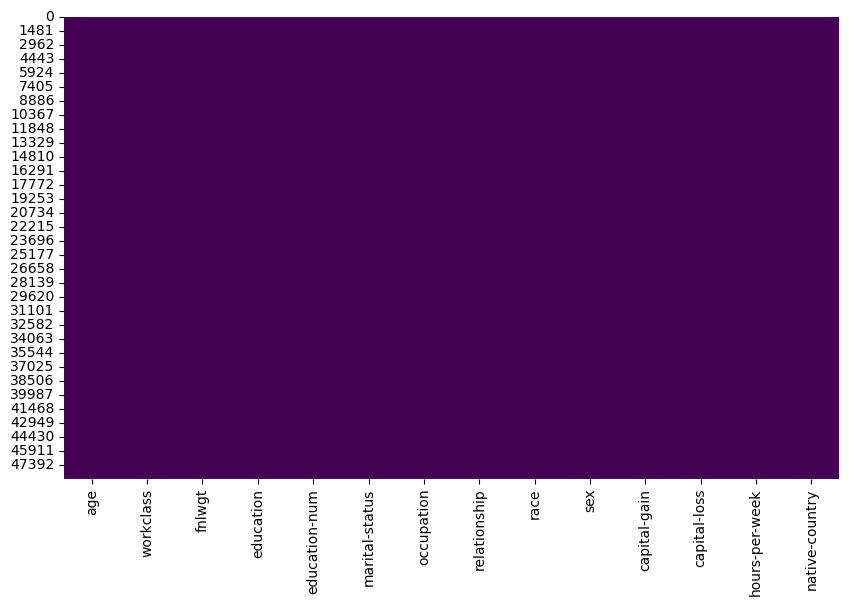

In [92]:
#check missing data 

#create missing value matrix
missing_matrix = X.isna()

#plot missing value matrix using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(missing_matrix, cbar=False, cmap='viridis')

plt.show()

In [93]:
#one hot encode categorical variables 

#convert object to category 
X[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']] = X[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']].astype('category')
#X.info()

#check missing data 
#sns.displot(
    #data=X.isna().melt(value_name="missing"),
    #y="variable",
    ##multiple="fill",
    #aspect=1.25
#)

# onehot encode the data to convert categorical variables into columns with 0 and 1 rows 
category = X.select_dtypes(include='category').columns
#category 

#one hot encode, get new columns with True or False values 
encoded = pd.get_dummies(X[category])
#encoded.head() 

# drop the old columns and join new encoded columns 
X = X.drop(category, axis=1)
X = X.join(encoded)

X.info()
print(X.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Columns: 111 entries, age to native-country_Yugoslavia
dtypes: bool(105), int64(6)
memory usage: 7.1 MB
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Unknown', 'workclass_Without-pay', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_N

C:\Users\sarah\AppData\Local\Temp\ipykernel_29732\38432868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']] = X[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']].astype('category')


In [94]:
X.value_counts(normalize=True)

age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  workclass_?  workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  workclass_Unknown  workclass_Without-pay  education_10th  education_11th  education_12th  education_1st-4th  education_5th-6th  education_7th-8th  education_9th  education_Assoc-acdm  education_Assoc-voc  education_Bachelors  education_Doctorate  education_HS-grad  education_Masters  education_Preschool  education_Prof-school  education_Some-college  marital-status_Divorced  marital-status_Married-AF-spouse  marital-status_Married-civ-spouse  marital-status_Married-spouse-absent  marital-status_Never-married  marital-status_Separated  marital-status_Widowed  occupation_?  occupation_Adm-clerical  occupation_Armed-Forces  occupation_Craft-repair  occupation_Exec-managerial  occupation_Farming-fishing  occupation_Handlers-cleaners  occupation_Mach

In [95]:
#preprocess y 

y.info()
y.head(5)

y['income'] = y['income'].str.replace('.', '') #difference between income_<=50K and income_<=50K. fixed 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   income  48842 non-null  object
dtypes: object(1)
memory usage: 381.7+ KB


C:\Users\sarah\AppData\Local\Temp\ipykernel_29732\3442700528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['income'] = y['income'].str.replace('.', '') #difference between income_<=50K and income_<=50K. fixed


In [96]:
(y['income'].unique()) #difference between income_<=50K and income_<=50K. fixed 

array(['<=50K', '>50K'], dtype=object)

In [97]:
#make boolean column 'income_>50K_True' and drop income column 

y['income_>50K_True'] = (y['income'] == '>50K').map({True: 1, False: 0})
#y.head()

y['income_>50K_True'] = y['income_>50K_True'].astype(bool)

y = y.drop('income', axis=1)

C:\Users\sarah\AppData\Local\Temp\ipykernel_29732\3075744260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['income_>50K_True'] = (y['income'] == '>50K').map({True: 1, False: 0})
C:\Users\sarah\AppData\Local\Temp\ipykernel_29732\3075744260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['income_>50K_True'] = y['income_>50K_True'].astype(bool)


In [98]:
y.info()
y.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   income_>50K_True  48842 non-null  bool 
dtypes: bool(1)
memory usage: 47.8 KB


,income_>50K_True
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,True
8,True
9,True


In [99]:
y.value_counts(normalize=True)

income_>50K_True
False               0.760718
True                0.239282
Name: proportion, dtype: float64

In [101]:
#Use train_test_split twice to get training, testing, and tuning dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify= y, random_state=21) 
#random forest does requires more training data

In [102]:
#check output

print(y_train.value_counts())
print(y_test.value_counts())

income_>50K_True
False               33439
True                10518
Name: count, dtype: int64
income_>50K_True
False               3716
True                1169
Name: count, dtype: int64


In [103]:
#RF model

print('max_features = ' + str(np.sqrt(X.shape[1]))) #around 11, 111 predictors 

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 11, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984 #reproducible results
                    )

#Fit our data
income_RF= RFC.fit(X_train,y_train)

max_features = 10.535653752852738


c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [104]:
#output of random forest
print('OOB error rate: ' + str(1-income_RF.oob_score_)) #0.1885

OOB error rate: 0.1885251495779967


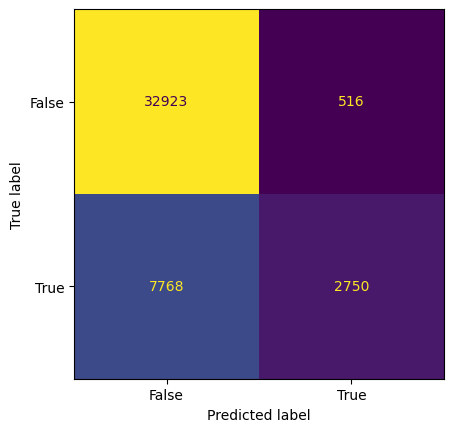

In [105]:
#confusion matrix 
ConfusionMatrixDisplay.from_estimator(income_RF,X_train,y_train, colorbar= False)

#TP = 2750
#TN = 32923
#FP = 516
#FN = 7768

In [106]:
#accuracy

income_RF.score(X_train,y_train) #0.8115

#precision (TP)/(TP + FP) accuracy of positive predictions 

#(2750)/(2750 + 516) =  2750/3266 = 0.8420

#recall (TP)/(TP + FN) ratio of correctly predicted positive observations to the total actual positives

#(2750)/(2750 + 7768) = 2750/10518 = 0.26146

0.8115430989375981

In [107]:
#row predictions

class_probabilities = RFC.predict_proba(X_test)
#0 (neg class),1 (pos class)
probabilities_dataframe = pd.DataFrame(class_probabilities, columns=['0', '1'])
#print(probabilities_dataframe)

#highest probability of being a pos case
pos_case = probabilities_dataframe.sort_values(by='1', ascending=False)
print(pos_case) #3131  0.387805  0.612195

#highest probability of being a negative case
neg_case = probabilities_dataframe.sort_values(by='0', ascending=False)
print(neg_case) #1178  0.968541  0.031459 

             0         1
3131  0.387805  0.612195
1001  0.392840  0.607160
382   0.394612  0.605388
990   0.395095  0.604905
396   0.396279  0.603721
...        ...       ...
4400  0.966820  0.033180
3031  0.967038  0.032962
2737  0.967383  0.032617
4047  0.967806  0.032194
1178  0.968541  0.031459

[4885 rows x 2 columns]
             0         1
1178  0.968541  0.031459
4047  0.967806  0.032194
2737  0.967383  0.032617
3031  0.967038  0.032962
4400  0.966820  0.033180
...        ...       ...
396   0.396279  0.603721
990   0.395095  0.604905
382   0.394612  0.605388
1001  0.392840  0.607160
3131  0.387805  0.612195

[4885 rows x 2 columns]


[0.20005352 0.11981283 0.04599518 ... 0.53137177 0.15308315 0.0941304 ]


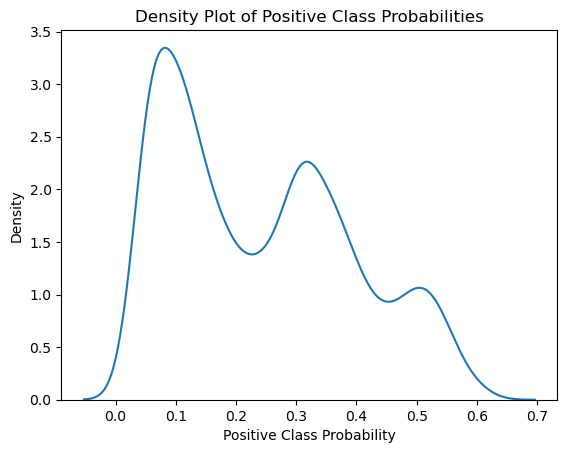

In [108]:
#density plot of positive class probabilities

class_probabilities = RFC.predict_proba(X_test)

#positive class probabilites 
positive_class_probabilities = class_probabilities[:, 1]
print(positive_class_probabilities)

sns.kdeplot(positive_class_probabilities)
plt.title("Density Plot of Positive Class Probabilities")
plt.xlabel("Positive Class Probability")

plt.show()

#positive class probabilites are not strong; most positive class probabilities are less than 0.5, with most at 0.1

In [109]:
#sorted list of feature importances
pd.DataFrame(income_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)

#the most important features are marital-status_Married-civ-spouse, education-num, relationship_Husband, age, hours-per-week

,importance
marital-status_Married-civ-spouse,0.133243
education-num,0.122311
relationship_Husband,0.109961
age,0.088478
hours-per-week,0.068371
...,...
native-country_El-Salvador,0.000000
native-country_England,0.000000
native-country_France,0.000000
native-country_Germany,0.000000


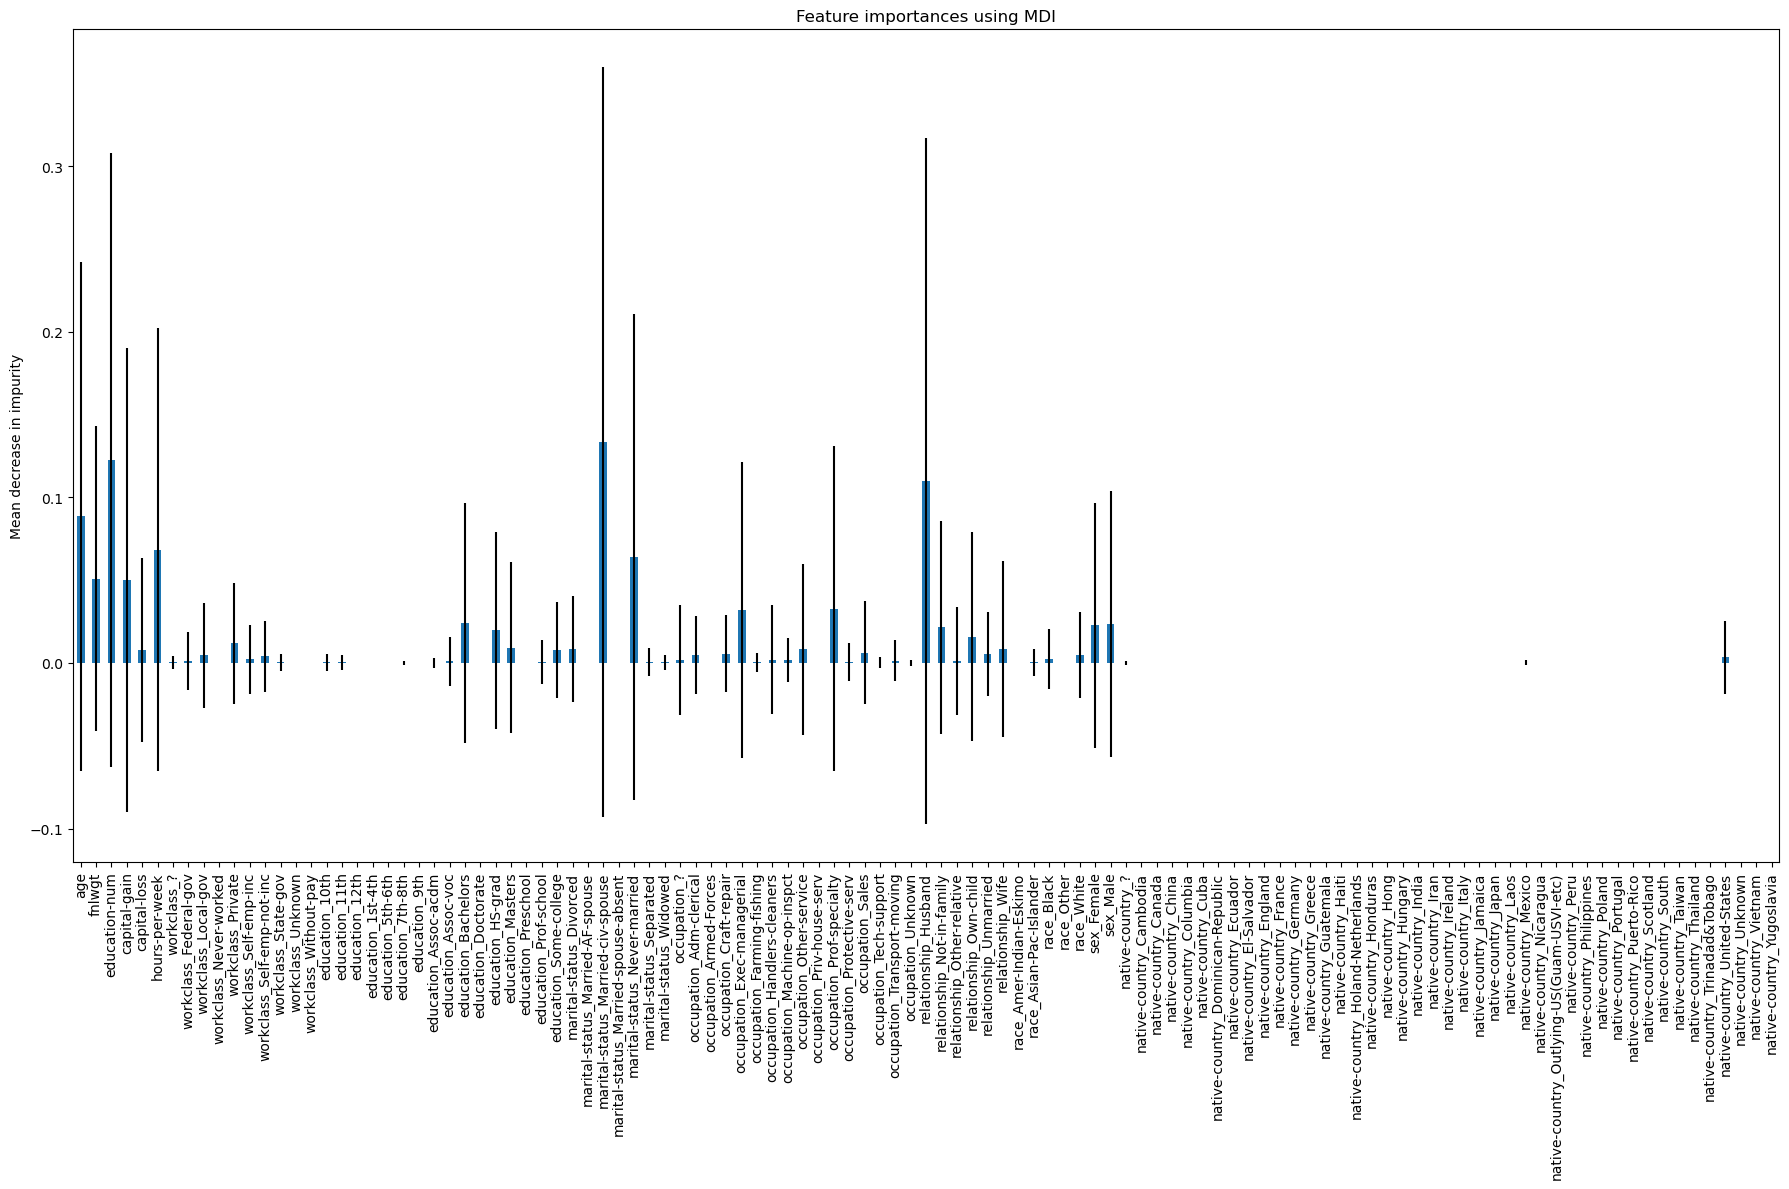

In [110]:
#feature importances using MDI

importances = income_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in income_RF.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=(18, 12))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [111]:
#permutation feature importance 

result = permutation_importance(
    income_RF, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2,scoring='accuracy'
)

#Combine results and column names to visualize 
forest_importances = pd.Series(result.importances_mean, index=X.columns)

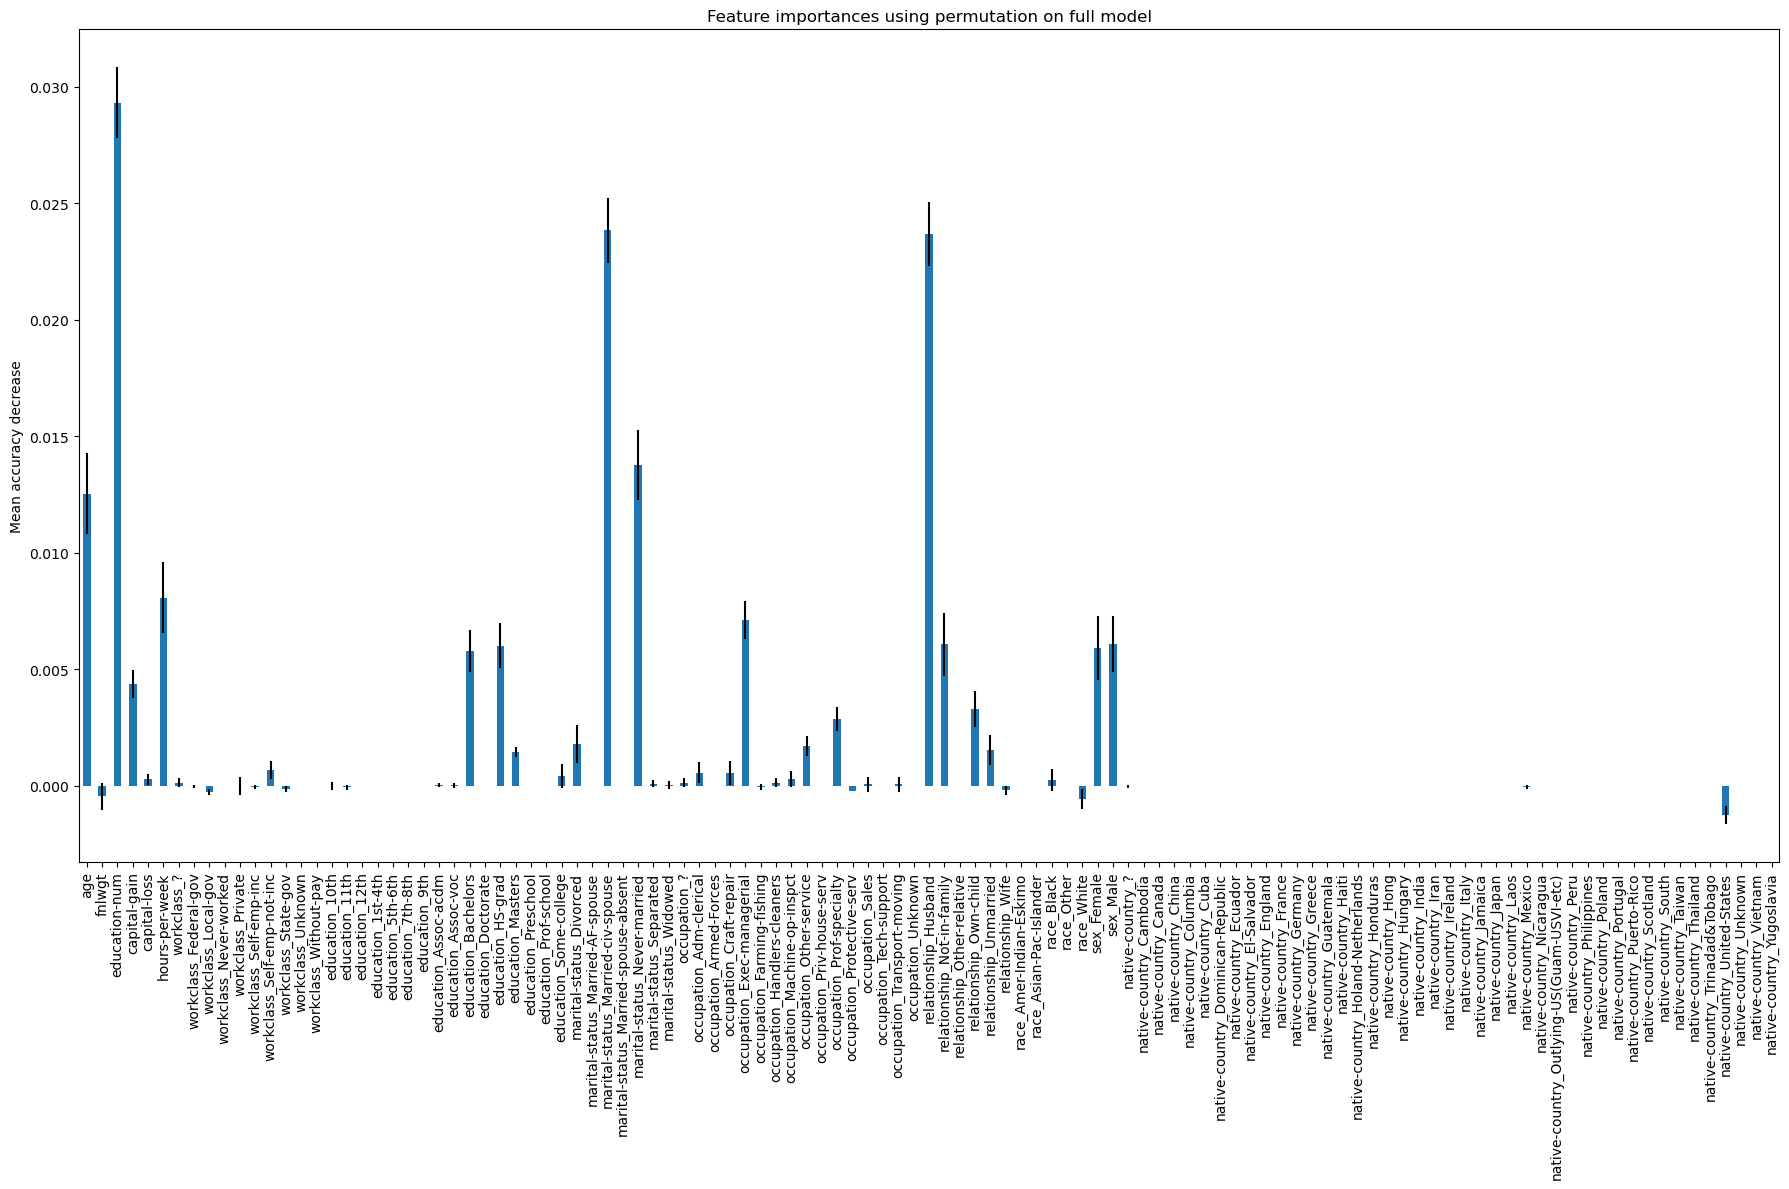

In [112]:
#permutation feature importance 

fig, ax = plt.subplots(figsize=(18, 12))

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#the same features are detected as most important using both methods; the relative importances vary
#PFI directly measures the impact of a single features; MDI can attribute importance to one feature in a correlated pair

In [113]:

n_estimators_list = [100,200,300,400,500,600,700,800,900,1000, 1100, 1200, 1300, 1400, 1500, 1600]
forest_list = [RandomForestClassifier( n_estimators = n,
            max_features= 11, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p)
                    bootstrap= True, #<-Whether bootstrap samples are used when building trees
                    max_samples = 100,  #<- Size of sample to draw each time.
                    min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                    max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                    max_depth= None, #<-The maximum depth of the tree
                    oob_score=True,
                   warm_start=True,
                    random_state= 1984).fit(X_train, y_train) for n in n_estimators_list]


forest_list[:3]
#DataConversionWarning 

c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

[RandomForestClassifier(max_features=11, max_samples=100, min_samples_leaf=5,
                        oob_score=True, random_state=1984, warm_start=True),
 RandomForestClassifier(max_features=11, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=11, max_samples=100, min_samples_leaf=5,
                        n_estimators=300, oob_score=True, random_state=1984,
                        warm_start=True)]

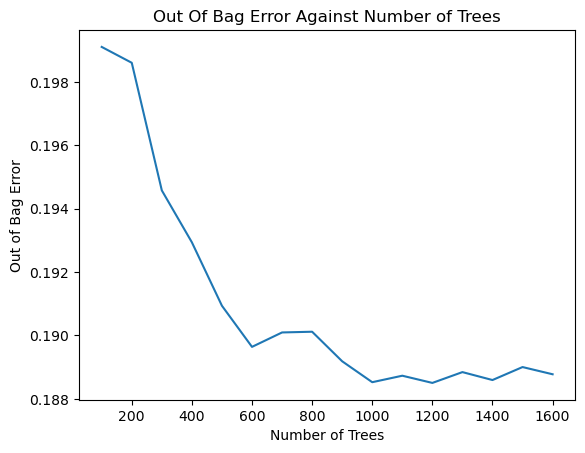

In [115]:
#visualize the results of the random forest

oob_errors = ([1-i.oob_score_ for i in forest_list])
plt.plot(n_estimators_list,oob_errors)
plt.title('Out Of Bag Error Against Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Out of Bag Error')
plt.show()

In [116]:
# optimal trees 

pd.DataFrame(list(zip(n_estimators_list,oob_errors)), columns = ['number of trees','oob_error'])
#11	1200	0.188502

,number of trees,oob_error
0,100,0.199104
1,200,0.198603
2,300,0.194577
3,400,0.192939
4,500,0.190937
5,600,0.189640
6,700,0.190095
7,800,0.190118
8,900,0.189185
9,1000,0.188525


In [117]:
#random forest model with 1200 trees
income_RF_eng = forest_list[11]
income_RF_eng #good

RandomForestClassifier(max_features=11, max_samples=100, min_samples_leaf=5,
                       n_estimators=1200, oob_score=True, random_state=1984,
                       warm_start=True)

original model error: 0.1885251495779967
new model error: 0.1885024000727984


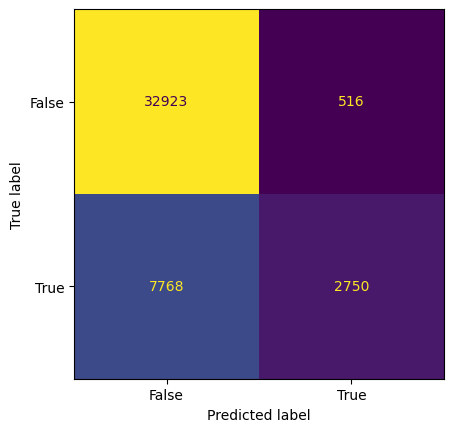

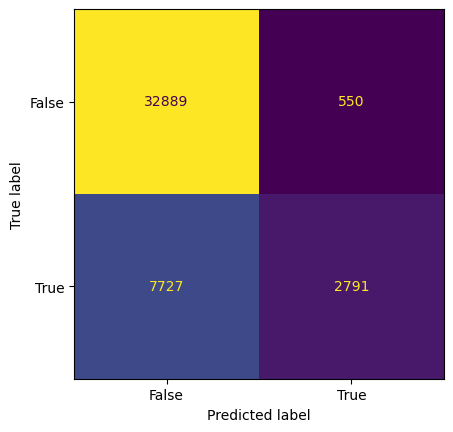

In [118]:
#confusion matrices between our 2 random forest models and the associated total error rates

#original
print('original model error: ' +str(1-income_RF.oob_score_))
ConfusionMatrixDisplay.from_estimator(income_RF,X_train,y_train, colorbar= False)

#New
print('new model error: ' + str(1-income_RF_eng.oob_score_))
ConfusionMatrixDisplay.from_estimator(income_RF_eng,X_train,y_train, colorbar= False)

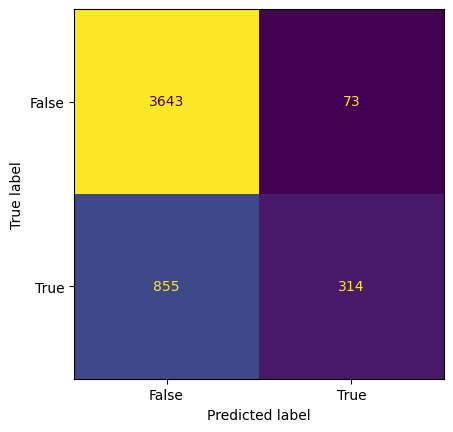

In [123]:
#.predict function on testing data with new model

income_predict = income_RF_eng.predict(X_test)

#create confusion matrix of test data predictions
ConfusionMatrixDisplay.from_predictions(y_test,income_predict, colorbar= False)

In [124]:
# parameters to set for the random forest

max_features_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

forest_list2 = [RandomForestClassifier(n_estimators = 1200,
            max_features= n, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                    bootstrap= True, #<-Whether bootstrap samples are used when building trees
                    max_samples = 100,  #<- Size of sample to draw each time.
                    min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                    max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                    max_depth= None, #<-The maximum depth of the tree
                    oob_score=True,
                   warm_start=True,
                    random_state= 1984).fit(X_train, y_train) for n in max_features_list]
forest_list2[:3]

c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

[RandomForestClassifier(max_features=1, max_samples=100, min_samples_leaf=5,
                        n_estimators=1200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=2, max_samples=100, min_samples_leaf=5,
                        n_estimators=1200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=3, max_samples=100, min_samples_leaf=5,
                        n_estimators=1200, oob_score=True, random_state=1984,
                        warm_start=True)]

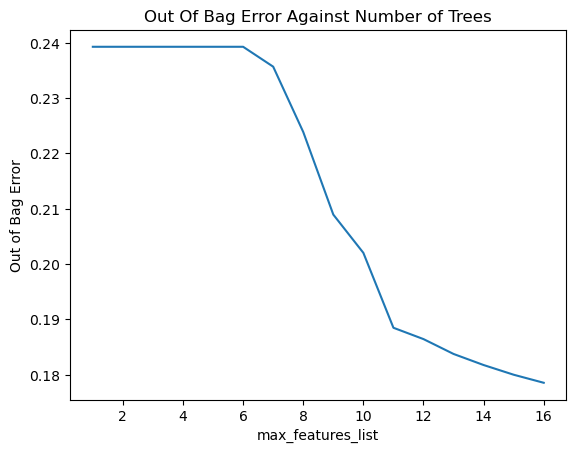

In [125]:
#optimal features 

oob_errors1 = ([1-i.oob_score_ for i in forest_list2])
  #for error simply do 1-forest.oob_score_ 
plt.plot(max_features_list,oob_errors1)
plt.title('Out Of Bag Error Against Number of Trees')
plt.xlabel('max_features_list')
plt.ylabel('Out of Bag Error')
plt.show() 
# 6 is the right value to use in our random forest without overfitting

In [126]:
#random forest model with 6 features
income_RF_tune = forest_list2[5]
income_RF_tune 

RandomForestClassifier(max_features=6, max_samples=100, min_samples_leaf=5,
                       n_estimators=1200, oob_score=True, random_state=1984,
                       warm_start=True)

In [135]:
feature_names = X_train.columns.tolist()

#Create an explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=['True', 'False'],
    discretize_continuous=True
)

# Choose an observation to explain
observation = 85

# Get the explanation for RF
exp = explainer.explain_instance(
    X_train.values[observation],
    income_RF_eng.predict_proba,
    num_features=15
)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)


c:\Users\sarah\miniconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'False Positive Rate')

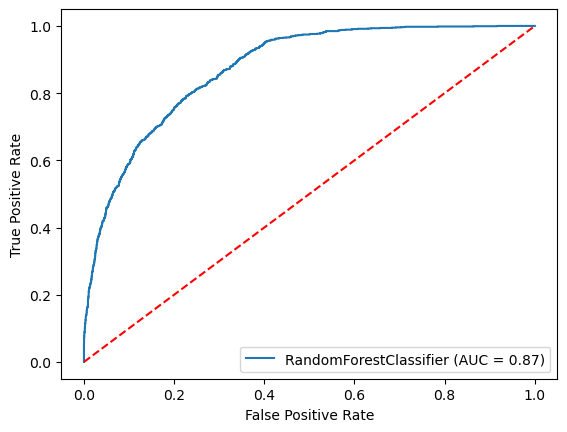

In [136]:
# how relative true positives compare to the false positives with ROC curve
# plot a ROC curve.

#Quickest and easist method is to simply use the sklearn function RocCurveDisplay with our model and testing features + target
#This will give us an ROC plot with all reasonable thresholds given the probabilities of prediction
metrics.RocCurveDisplay.from_estimator(income_RF_tune, X_test,y_test)
#Set labels and midline...
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#AUC of 0.87 relatively high

In [137]:
#optimal threshold

#First get prediction probabilities of test data, only want positive class so extract second column
pred = income_RF_tune.predict_proba(X_test)[:,1]
#Use roc_curve function to get fpr, tpr and threshold values
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
pd.DataFrame(list(zip(thresholds, tpr, fpr)),columns = ['thresholds','tpr','fpr']).head(27) #good

,thresholds,tpr,fpr
0,inf,0.000000,0.000000
1,0.482302,0.000855,0.000000
2,0.445423,0.053037,0.000000
3,0.444853,0.053037,0.000269
4,0.438118,0.071856,0.000269
5,0.437998,0.071856,0.000538
6,0.436891,0.076989,0.000538
7,0.436755,0.076989,0.000807
8,0.435206,0.084688,0.000807
9,0.435170,0.084688,0.001076


In [138]:
#index of best threshold, where true postive rate is highest and false positive rate is the lowest

ix = np.argmax(tpr-fpr) #np.argmax returns the index of maximum values along and axis
print('Best threshold: ' + str(thresholds[26]))

Best threshold: 0.4289110889249856


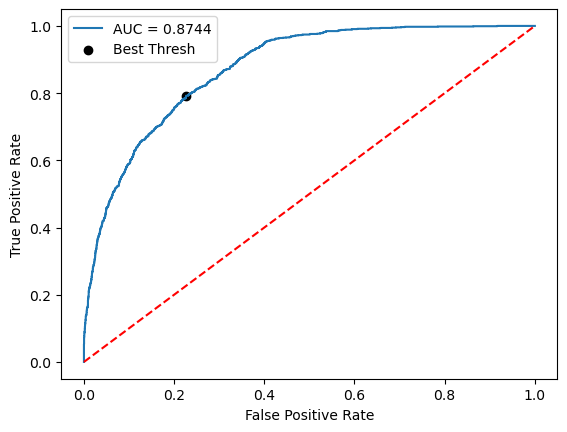

In [139]:
#roc curve for the model with best threshold highlighted

#Get auc score first to add to plot
auc = metrics.roc_auc_score(y_test, pred)
#plot fpr and tpr
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % auc) 
#add in best threshold highlight
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Thresh')
# axis labels
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

In [ ]:
# the model performs with relatively high discriminatory power with AUC = 0.8744, able to accurately distinguish between classes (income levels)